# データの読み込み,可視化 と Augmentationの実行

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
import cv2
from PIL import Image

In [2]:
# 自作クラスの読み込み
import sys
sys.path.append('../src/preprocess')
sys.path.append('../src/dataset')
from augmentation import ObjectDetectionAugmentation
from dataset import Dataset

- yamlファイルからconfigの読み込み

In [3]:
import yaml
with open('../config/config_train.yml', 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

- train, test csvの読み込み

In [4]:
root_dir  = '../input/tensorflow-great-barrier-reef'
train_path = f'{root_dir}/train.csv'
test_path = f'{root_dir}/test.csv'

def get_img_path(df):
    df['image_path'] = f'{root_dir}/train_images/video_{df.video_id}/{df.video_frame}.jpg'
    return df

def get_annotes(df):
    df['dict_annotations'] = df['annotations'].apply(lambda x: eval(x)) # annotationsが文字列として入っているため、eval()
    df['list_annotations'] = df['dict_annotations'].apply(lambda x: [list(annote.values()) for annote in x]) # リスト型式にcast
    df['n_annotations'] = df['dict_annotations'].apply(len)
    return df

def read_train(train_path):
    train = pd.read_csv(train_path)
    train = get_annotes(train)
    train = get_img_path(train)
    return train

In [5]:
train = read_train(train_path)

- Kaggleのページ上でディスプレイされている画像の中でヒトデが多い画像を探す

In [6]:
max_annots = 0
max_id = "" 
video_id = 0
for video_frame in range(1001, 1020):
    image_id = f'{video_id}-{video_frame}'
    len_annots = train[train['image_id']==image_id]['n_annotations'].item()
    if len_annots > max_annots:
        max_annots = len_annots
        max_id = image_id

print(max_id)
print(max_annots)

0-1001
1


#  サンプルデータ読み込み
- 可視化参考元
https://www.kaggle.com/remekkinas/yolox-training-pipeline-cots-dataset-lb-0-507
- image_id: 0-1001, 1-10001

In [7]:
# 全データ存在する場合
image_paths = []
sample_bboxes = []
max_frame0 = 100
max_frame1 = 100
max_frame2 = 100
list_id = list(train['image_id'])
for video_id, frame_list in enumerate([range(max_frame0 + 1), range(max_frame1 + 1), range(max_frame2 + 1)]):
    for video_frame in frame_list:
        if f'{video_id}-{video_frame}' in list_id:
            _img_path = f'../input/tensorflow-great-barrier-reef/train_images/video_{video_id}/{video_frame}.jpg'
            _bboxes = train[train['image_id']==f'{video_id}-{video_frame}']['list_annotations'].item()
            image_paths.append(_img_path)
            sample_bboxes.append(_bboxes)

In [8]:
# # 二枚の画像でsample
# # 全データを読み込む場合image_pathsを書き換える
# image1_path = '../input/tensorflow-great-barrier-reef/train_images/video_0/1001.jpg'
# image2_path = '../input/tensorflow-great-barrier-reef/train_images/video_1/10001.jpg'

# image_paths = [image1_path, image2_path]

# # sample_bboxesをimage_pathsに対応するimage_idにする
# sample_ids = ['0-1001', '1-10001']
# sample_bboxes = []
# for sample_id in sample_ids:
#     _bboxes = train[train['image_id']==sample_id]['list_annotations'].item()
#     sample_bboxes.append(_bboxes)

- Augmentationをしない場合

In [9]:
dataset = Dataset(file_paths=image_paths, bboxes=sample_bboxes)


- Augmentation をする場合

In [10]:
# # augmentationを考慮したdataset
# transformer = ObjectDetectionAugmentation(config['transforms_args'])
# dataset = Dataset(file_paths=[image1_path, image2_path], bboxes=sample_bboxes, transform=transformer.transform)

- 可視化関数の定義

In [11]:
# 可視化用関数
def draw_bboxes(img, bboxes):
    for i in range(len(bboxes)):
        box = bboxes[i]
        x0 = int(box[0])
        y0 = int(box[1])
        x1 = x0 + int(box[2])
        y1 = y0 + int(box[3])
        cv2.rectangle(img, (x0, y0), (x1, y1), (255, 0, 0), 2)
    return img

def draw_bboxes_predict(img, bboxes, scores, bbclasses, confthre, classes_dict):
    img = draw_bboxes(img, bboxes)
    for i in range(len(bboxes)):
        box = bboxes[i]
        cls_id = int(bbclasses[i])
        score = scores[i]
        if score < confthre:
            continue
        cv2.putText(img, '{}:{:.1f}%'.format(classes_dict[cls_id], score * 100), (box[0], box[1] - 3), cv2.FONT_HERSHEY_PLAIN, 0.8, (255,0,0), thickness = 1)
    return img


# def display_cv2img(cv2_img):
#     out_img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
#     display(Image.fromarray(out_img))

# サンプル画像の表示

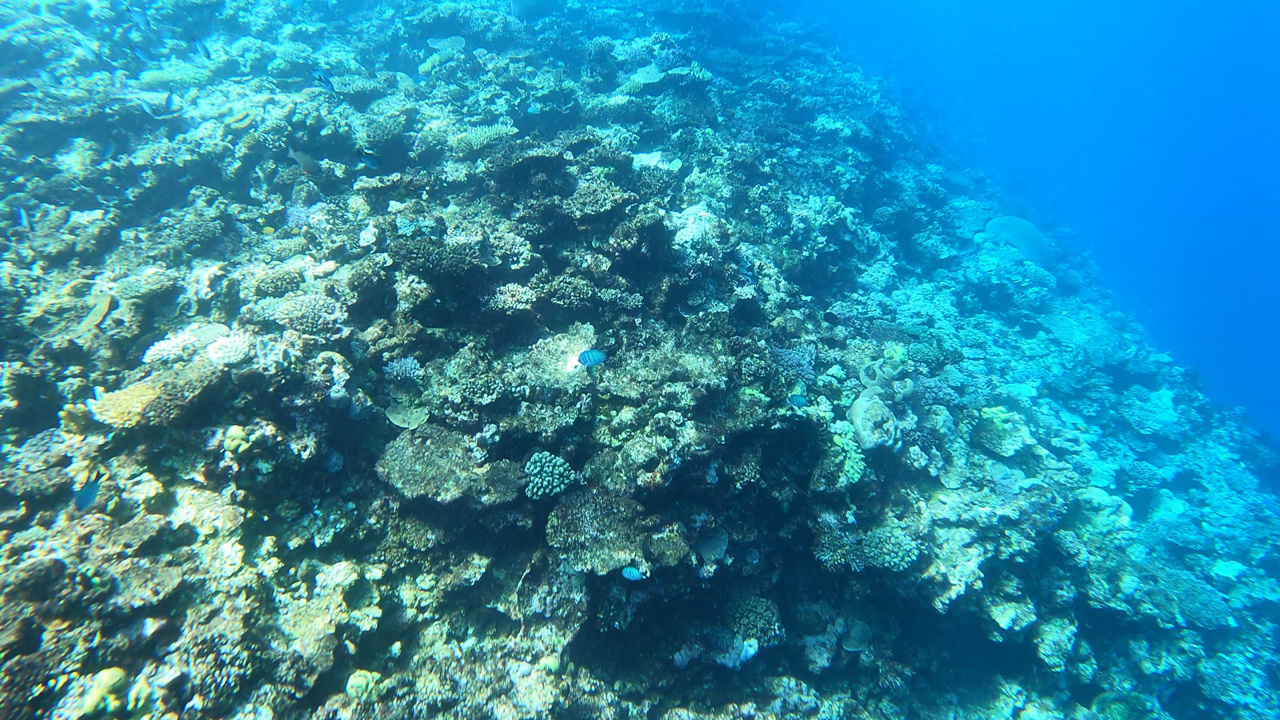

In [14]:
out_img= draw_bboxes(*dataset.__getitem__(0))
display(Image.fromarray(out_img))

- 推論時想定可視化サンプル

In [15]:
# # Get predictions
# # bboxes, bbclasses, scores = yolox_inference(img, model, test_size)
# bboxes, bbclasses, scores = sample_bboxes, [0], [0.99]
# # Draw predictions
# out_image = draw_bboxes_predict(sample_img, bboxes, scores, bbclasses, 0.0, {0: 'hitode'})

# # Since we load image using OpenCV we have to convert it 
# out_image = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)
# display(Image.fromarray(out_image))

# Augmentation
- 参考
    - https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/ 
    - https://github.com/albumentations-team/albumentations

In [16]:
config['transforms_args']

{'augment_args': {'vertical_flip': {'p': 0.5},
  'horizontal_flip': {'p': 0.5},
  'random_crop': {'width': 450, 'height': 450},
  'random_brightness_contrast': {'p': 0.2}},
 'bbox_param': {'format': 'coco',
  'min_area': 100,
  'min_visibility': 0.1,
  'label_fields': []},
 'compile': 'compose'}

In [17]:
transformer = ObjectDetectionAugmentation(config['transforms_args'])

In [18]:
sample_imgs, sample_bboxes = [], []
# for idx in range(len(image_paths)):
for idx in range(2):
    sample_img, sample_bbox = dataset.__getitem__(idx)
    sample_imgs.append(sample_img)
    sample_bboxes.append(sample_bbox)

TODO: サンプルを書き換える

In [19]:
# sample define dataset transformed 
dataset_transform = Dataset(file_paths=image_paths, bboxes=sample_bboxes, transform=transformer.transform)

In [20]:
%%time
# 一枚だけ変換
_img, _bboxes = transformer.transform(sample_img, sample_bbox)
#可視化
# display(Image.fromarray(draw_bboxes(_img, _bboxes)))

CPU times: user 1.42 ms, sys: 783 µs, total: 2.2 ms
Wall time: 970 µs


In [21]:
%%time
#　リストを全て変換
image_list, bboxes_list = transformer.transform_data(sample_imgs, sample_bboxes)
#可視化
# for _i, _b in zip(image_list, bboxes_list):
#     display(Image.fromarray(draw_bboxes(_i, _b)))

CPU times: user 3.81 ms, sys: 3.2 ms, total: 7.01 ms
Wall time: 4.39 ms


- Augmentationテスト

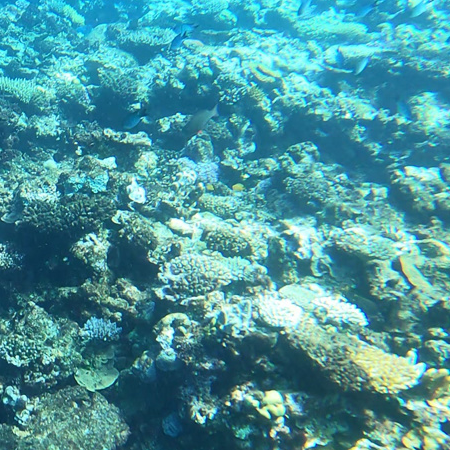

In [22]:
import albumentations as A

transform = A.Compose([
    A.RandomCrop(width=450, height=450),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='coco', min_area=100, min_visibility=0.1, label_fields=[]))

transformed = transform(image=sample_img, bboxes=sample_bbox)
transformed_img = transformed['image']
transformed_bboxes = transformed['bboxes']

transformed_img = draw_bboxes(transformed_img, transformed_bboxes)
display(Image.fromarray(transformed_img))

In [43]:
from torch.utils.data import Dataset
class Dataset(Dataset):
     
    def __init__(self, file_paths, bboxes, transform=None):
        self.file_paths = file_paths
        self.bboxes = bboxes
        self.transform = transform
         
    def __len__(self):
        return len(self.file_paths)
 
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        bboxes = self.bboxes[idx]
 
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image, bboxes = self.transform(image=image, bboxes=bboxes)
        return image, bboxes

# train_video の可視化
- 参考: https://www.kaggle.com/werooring/basic-eda-starter-for-everyone

In [23]:
import matplotlib
from matplotlib import animation, rc
matplotlib.rcParams['animation.embed_limit'] = 2**128
rc('animation', html='jshtml')

def create_animation(imgs, frame_interval=130):
    fig = plt.figure(figsize=(14, 8))
    plt.axis('off')
    img = plt.imshow(imgs[0])

    def animate(i):
        img.set_array(imgs[i])
        return [img]

    return animation.FuncAnimation(fig, animate, frames=len(imgs), interval=frame_interval)

In [64]:
len(sample_bboxes)

23501

In [40]:
max0 = 12347 # (6708) (1000 * 6) + 708
max1 = 11374 # (8232) (1000 * 8) + 232
max2 = 10759 # (8561) (1000 * 8) + 561

In [71]:
atr_list = [1000] * 6 + [708] + [1000] * 8 + [232] + [1000] * 8 + [561]
atr_list = [4000] + [2708] + [4000] + [4232] + [4000] + [4561]


MovieWriter ffmpeg unavailable; using Pillow instead.


saved ~../input/tensorflow-great-barrier-reef/train_images/video_0/7798.jpg .gif


MovieWriter ffmpeg unavailable; using Pillow instead.


saved ~../input/tensorflow-great-barrier-reef/train_images/video_0/12347.jpg .gif


MovieWriter ffmpeg unavailable; using Pillow instead.


saved ~../input/tensorflow-great-barrier-reef/train_images/video_1/5555.jpg .gif


MovieWriter ffmpeg unavailable; using Pillow instead.


saved ~../input/tensorflow-great-barrier-reef/train_images/video_1/11374.jpg .gif


MovieWriter ffmpeg unavailable; using Pillow instead.


saved ~../input/tensorflow-great-barrier-reef/train_images/video_2/4871.jpg .gif


MovieWriter ffmpeg unavailable; using Pillow instead.


saved ~../input/tensorflow-great-barrier-reef/train_images/video_2/10759.jpg .gif


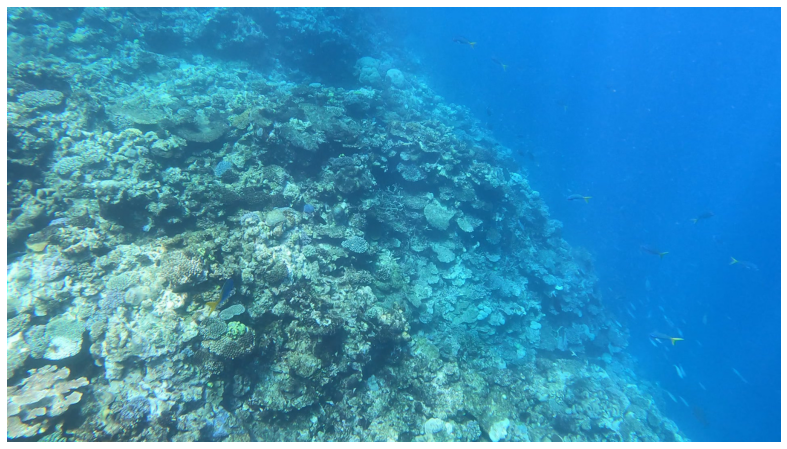

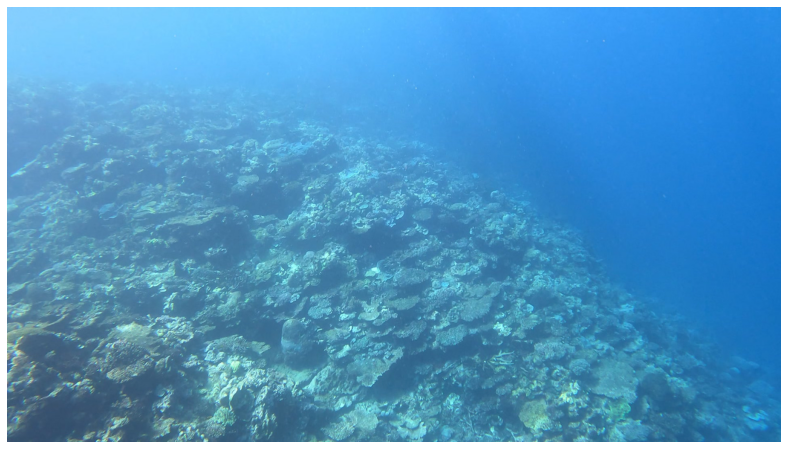

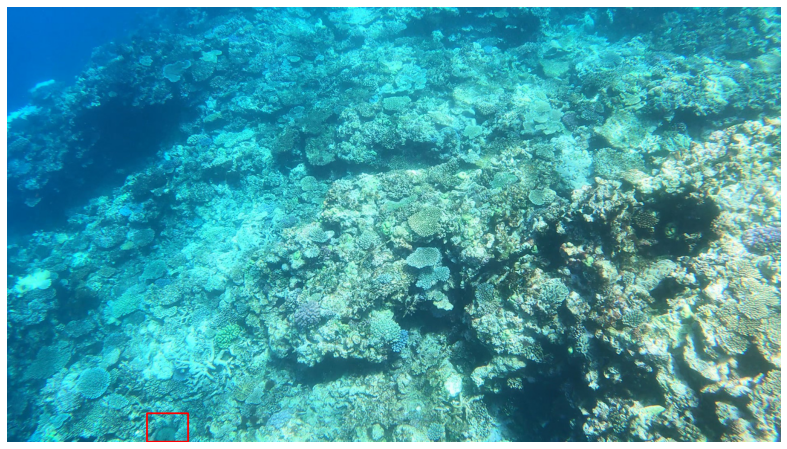

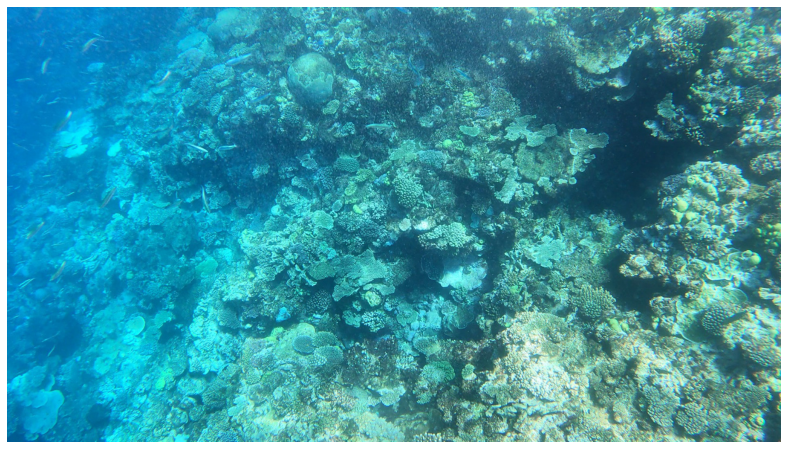

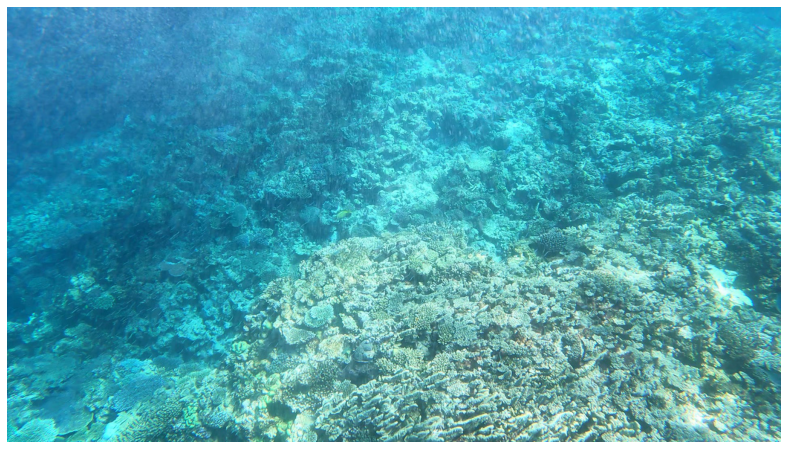

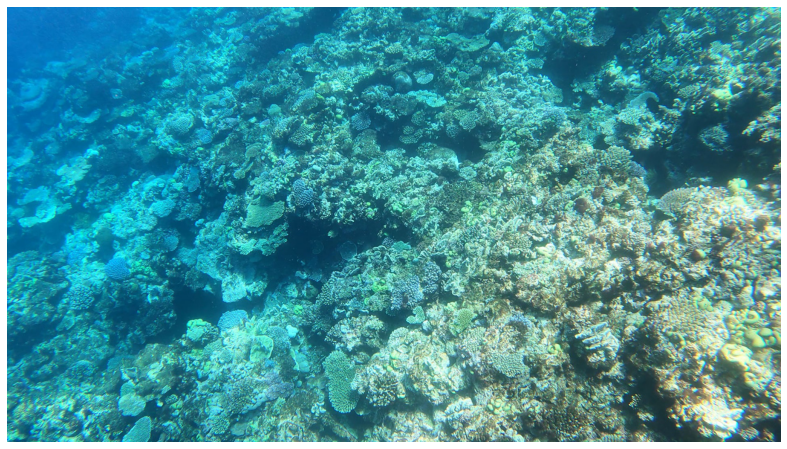

In [72]:
# start = 0
# frame_interval = 120 
# for i, atr_num in enumerate(atr_list):
#     _image_paths = image_paths[start: start+atr_num]
#     _sample_bboxes = sample_bboxes[start: start+atr_num]
#     _dataset = Dataset(file_paths=_image_paths, bboxes=_sample_bboxes)
#     ani = create_animation(
#         [draw_bboxes(img, bboxes) for img, bboxes in _dataset],
#         frame_interval=frame_interval
#     )
#     ani.save(f'cots_train_{i}.gif')
#     del ani
#     print(f'saved ~{_image_paths[-1]} .gif')
    
#     start += atr_num

In [ ]:
frame_interval = 120 # set smaller number if you want to play fast, otherwise set bigger
# ani = create_animation(
#     [draw_bboxes(img, bboxes) for img, bboxes in dataset],
#     frame_interval=frame_interval
# )
# ani.save("cots_train.gif")

# create_animation(
#     [draw_bboxes(img, bboxes) for img, bboxes in dataset],
#     frame_interval=frame_interval
# )


# DatasetClassの再設計

In [ ]:
root_dir  = '../input/tensorflow-great-barrier-reef'
class Dataset(Dataset):    
    def __init__(self, root_dir, file_paths, transform=None):
        train_path = f'{root_dir}/train.csv'
        train = read_train(train_path)
        bboxes = 
        self.file_paths = list(file_paths)
        self.bboxes = list(train.list_annotations)
        self.transform = transform
         
    def __len__(self):
        return len(self.file_paths)
 
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        bboxes = self.bboxes[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image, bboxes = self.transform(image=image, bboxes=bboxes)
        return image, bboxes